In [1]:
import requests
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime, timedelta
from copy import deepcopy
from tensorflow.keras.utils import to_categorical
import talib
from talib import abstract
import random
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Nadam

In [2]:
#　在現有的點附近生成可能的點
class Smote:
    def __init__(self,samples,N=10,k=5):
        self.n_samples,self.n_attrs=samples.shape
        self.N=N
        self.k=k
        self.samples=samples
        self.newindex=0
       # self.synthetic=np.zeros((self.n_samples*N,self.n_attrs))

    def over_sampling(self):
        N=int(self.N/100)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples)
        for i in range(len(self.samples)):
            nnarray=neighbors.kneighbors(self.samples[i].reshape(1,-1),return_distance=False)[0]
            #print nnarray
            self._populate(N,i,nnarray)
        return self.synthetic


    # for each minority class samples,choose N of the k nearest neighbors and generate N synthetic samples.
    def _populate(self,N,i,nnarray):
        for j in range(N):
            nn=random.randint(0,self.k-1)
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1

In [3]:
# 建立有關股票的類別
class Stock:
    stock_set = set()
    def __init__(self, stock_id, flag = 'test', date = datetime.strftime(datetime.today() - 1 * timedelta(days=365), "%Y-%m-%d"), end_date = datetime.strftime(datetime.today() , "%Y-%m-%d")):
        self.stock_id = stock_id
        self.__class__.stock_set.add(self.stock_id)
        self.data_dict = {"institutional_investors":self.institutional_investors, "price":self.price, "price_ma":self.price_ma}
        self.url = "http://api.finmindtrade.com/api/v2/data"
        self.date = date
        self.end_date = end_date
    # 抓取有關法人買賣超的資料
    def institutional_investors(self):
        parameter = {"stock_id": self.stock_id,
                     "date": self.date,
                     "end_date": self.end_date,
                     "dataset": "InstitutionalInvestorsBuySell"}
        headers = {'Connection': 'close'}
        data = requests.get(self.url, params = parameter, headers = headers)
        data = data.json()
        data = pd.DataFrame(data['data'])
        data.set_index('date', inplace = True)
        investment_trust = data[data['name'] == 'Investment_Trust']
        investment_trust.insert(2, 'investment_trust', investment_trust['buy'] - investment_trust['sell'])
        investment_trust = investment_trust.drop(columns = ['buy', 'name', 'sell', 'stock_id'])
        foreign_investor = data[data['name'] == 'Foreign_Investor']
        foreign_investor.insert(2, 'foreign_investor', foreign_investor['buy'] - foreign_investor['sell'])
        foreign_investor = foreign_investor.drop(columns = ['buy', 'name', 'sell', 'stock_id'])
        data = pd.merge(investment_trust, foreign_investor, on = ['date'])
        return data
    # 抓取價格
    def price(self):
        parameter = {"stock_id": self.stock_id,
             "date": self.date,
             "end_date": self.end_date,
             "dataset": "TaiwanStockPrice"}
        headers = {'Connection': 'close'}
        data = requests.get(self.url, params = parameter, headers = headers)
        data = data.json()
        data = pd.DataFrame(data['data'])
        data.set_index('date', inplace = True)
        data = data.drop(columns = ['Trading_money', 'spread', 'Trading_turnover', 'stock_id'])
        data.columns = ['volume', 'open', 'high', 'low', 'close']
        return data
    # 抓取價格並算出移動平均
    def price_ma(self, day):
        data = self.price()
        data[f'{day}_ma'] = data['close'].rolling(day).mean()
        return data
    # 抓取價格並找到最近9天的最大及最小值
    def max_min_price(self):
        df = self.price()
        df['close_min'] = df['close'].rolling(5).min()
        df['close_min'] = df['close_min'].shift(-2)
        df['close_max'] = df['close'].rolling(5).max()
        df['close_max'] = df['close_max'].shift(-2)
        df.loc[df.close == df.close_min, 'flag'] = 0
        df.loc[(df.close != df.close_min) & (df.close != df.close_max), 'flag'] = 1
        df.loc[df.close == df.close_max, 'flag'] = 2
        return df
    # 畫出時間與價格的關係圖並標記最近9天的最大及最小值
    def plot(self):
        df = self.max_min_price()
        buy_df = deepcopy(df)
        sell_df = deepcopy(df)
        buy_df.loc[df.flag!=0 , 'close'] = 0
        sell_df.loc[df.flag!=2 , 'close'] = 0
        plt.figure(figsize=(15, 8))
        plt.plot(df["close"])
        plt.scatter(buy_df.index, buy_df['close'], c = 'r', label = 'min in 11 days')
        plt.scatter(sell_df.index, sell_df['close'], c = 'black', label = 'max in 11 days')
        plt.ylim(df['close'].min()-10, df['close'].max()+10)
        plt.title(self.stock_id)
        plt.ylabel("price")
        plt.xlabel("date")
        date = datetime.strftime(datetime.today() - 1 * timedelta(days=365), "%Y-%m-%d")
        new_ticks = []
        for i in range(len(df.index)):
            denominator = int(len(df.index) / 10)
            new_ticks.append(df.index[i]) if i%denominator == 0 else 0
        plt.xticks(new_ticks)
        plt.legend()
    # 抓取相關指標
    def technical_index(self):
        df = self.max_min_price()
        df2 = self.institutional_investors()
        df['RSI'] = abstract.RSI(df) / 100
        df['CMO'] =(abstract.CMO(df)+100) / (2 *100)
        df['MACD'] =(abstract.MACD(df)['macd']+abstract.MACD(df)['macd'].max()) / (2 *abstract.MACD(df)['macd'].max())
        df['WILLR'] =(abstract.WILLR(df)+100) / (2 *100)
        df['WMA'] =abstract.WMA(df) / abstract.WMA(df).max()
        df['PPO'] =(abstract.PPO(df)+abstract.PPO(df).max()) / (2 *abstract.PPO(df).max())
        df['EMA'] =abstract.EMA(df) / abstract.EMA(df).max()
        df['ROC'] =(abstract.ROC(df)+abstract.ROC(df).max()) / (2 *abstract.ROC(df).max())
        df['SMA'] =abstract.SMA(df) / abstract.SMA(df).max()
        df['TEMA'] =abstract.TEMA(df) / abstract.TEMA(df).max()
        df['CCI'] =(abstract.CCI(df)+abstract.CCI(df).max()) / (2 *abstract.CCI(df).max())
        df['investment_trust'] = (df2['investment_trust'] + df2['investment_trust'].max()) / (2*df2['investment_trust'].max())
        df['foreign_investor'] = (df2['foreign_investor'] + df2['foreign_investor'].max()) / (2*df2['foreign_investor'].max())
        df = df.drop(columns=['volume', 'open', 'high', 'low', 'close', 'close_max', 'close_min'])
        df = df.dropna()
        return df

In [4]:
# 建立交易類別且為股票的父類別
class Trade(Stock):
    def __init__(self, stock_id,flag = 'test', date = datetime.strftime(datetime.today() - 1 * timedelta(days=365), "%Y-%m-%d"), end_date = datetime.strftime(datetime.today() , "%Y-%m-%d"), balance = 1000000, fee = 0.00625, tax = 0.003, buy_flag = False, sell_flag = False):
        super().__init__(stock_id, flag, date, end_date)
        self.balance = balance
        self.fee = fee
        self.tax = tax
        self.buy_flag = buy_flag
        self.sell_flag = sell_flag
    # 進行前置作業
    def preprocessing(self):
        data1 = self.data_dict["price_ma"](10)
        data2 = self.data_dict["price_ma"](20)
        data3 = self.data_dict["institutional_investors"]()
        data = pd.merge(data1, data2, on = ['date', 'volume', 'open', 'close', 'high', 'low'], how = "inner")
        data = pd.merge(data, data3, on = ['date'], how = "inner")
        zeros = np.zeros(len(data)).reshape((len(data)), 1)
        data['buy_or_sell'] = zeros    #先將明天買賣股數設為0
        data['shares'] = zeros  #先將股數設為0
        data['balance'] = zeros  #先將餘額設為0
        data['profit'] = zeros   #先將損益設為0
        data['return'] = zeros   #先將報酬率設為0
        return data
    # 制定根據法人買賣的交易策略
    def follow_IT(self):
        df = self.preprocessing()
        df['IT_flag'] = df['investment_trust'] > 0   #投信是否買超
        df['IT_buy_days'] = df['IT_flag'].rolling(3).sum()   #投信這三天買超的天數
        #當投信連續買超3天 且 外資今天也買超 且 大於十日平均 就設為買進訊號
        df['buy_flag'] = (df['IT_buy_days'] == 3)  & (df['close'] > df['10_ma']) & (df['foreign_investor'] > 0)
        #當投信不再連續買超 或 收盤價小於十日平均 就設為賣出訊號
        df['sell_flag'] = (df['investment_trust'] < 0) & (df['close'] < df['10_ma']) & (df['foreign_investor'] < 0)
        self.buy_flag = np.array(df['buy_flag'])
        self.sell_flag = np.array(df['sell_flag'])
    # 紀錄每次的交易並計算報酬率等資訊
    def trading(self):
        df = self.preprocessing()
        df['buy_flag'] = self.buy_flag
        df['sell_flag'] = self.sell_flag
        for index, row in df.iterrows():
            #因為第一天沒有昨天的資料所以會出現Error，因此使用try
            try:
                df.loc[index, 'shares'] = yesterday.shares    #先將今天的股數設成和昨天一樣若有買賣再運算
                df.loc[index, 'balance'] = yesterday.balance  #先將今天的餘額設成和昨天一樣若有買賣再運算
                #當昨天的應買賣股數不等於0時，代表今天會執行買賣
                #(附註1：因為三大法人買賣超收盤之後才會知道因此所有動作都只能隔一天才能執行)
                if yesterday.buy_or_sell != 0 :
                    df.loc[index, 'buy_or_sell'] = 0    #將應買賣股數變回0
                    df.loc[index, 'shares'] = yesterday.shares + yesterday.buy_or_sell   #今日庫存股數為昨日股數加上應買股數
                    #今日餘額為昨日餘額加上今天交易股數乘上今天開盤價扣掉手續費和證交稅
                    df.loc[index, 'balance'] = yesterday.balance - yesterday.buy_or_sell*df.loc[index, 'open']*(1 + (self.fee + self.tax))  

                #當今天買進訊號出現的時候 且 今天的餘額夠買一張股票 明天開盤就買進
                #(附註2：應該使用明天的開盤價，不過明天還沒開盤不會知道開盤價，所以用今天收盤的漲停價來推算餘額夠不夠)
                if (df.loc[index, 'buy_flag']) and ((df.loc[index, 'balance'] - df.loc[index, 'close'] * 1.1 * 1000) > 0):  
                    shares = int(df.loc[index, 'balance'] / (df.loc[index, 'close'] * 1.1 * 1000))   #先估算餘額可以買幾股
                    df.loc[index, 'buy_or_sell'] = shares * 1000  #將預估購買的股數填入
                #當今天賣出訊號出現的時候 且 庫存股票股數大於0 明天開盤就賣出
                elif (df.loc[index, 'sell_flag']) and (df.loc[index, 'shares'] > 0):
                    df.loc[index, 'buy_or_sell'] = int(df.loc[index, 'shares'] * -1)   #將預估賣出的股數填入

                df.loc[index, 'profit'] = (df.loc[index, 'close'] * df.loc[index, 'shares'] + df.loc[index, 'balance']) - self.balance
                df.loc[index, 'return'] = round(df.loc[index, 'profit']/self.balance *100, 2)
                if (df.loc[index, 'shares'] > 0) or (yesterday.shares > 0):
                    df.loc[index, 'daily_return'] = round((df.loc[index, 'close'] - yesterday.close)/yesterday.close *100, 2) 
                else:
                    df.loc[index, 'daily_return'] = 0
                yesterday = df.loc[index]    #完成資料更新後將其設為下一天的昨天

            except UnboundLocalError:
                df.loc[index, 'balance'] = self.balance
                yesterday = df.loc[index]
        return df
    # 計算Sharpe Ratio、平均報酬和勝率
    def summary(self):  
        df = self.trading()
        df['last_return'] = df['return'].shift(-1)
        return_list = []
        flag = True
        for index, row in df.iterrows():
            if flag:
                if df.loc[index, 'buy_or_sell'] > 0 :
                    before_return = df.loc[index, 'return']
                    flag = False
            if flag == False:
                if df.loc[index, 'buy_or_sell'] < 0:
                    after_return = df.loc[index, 'last_return'] 
                    return_list.append(after_return - before_return)
                    flag = True
        return_arr = np.array(return_list)
        mean = df[df['daily_return'] != 0]['daily_return'].mean()
        std = np.std(df[df['daily_return'] != 0]['daily_return'], ddof = 1)
        days = len(df[df['daily_return'] != 0])
        times = len(return_arr)
        if times != 0:
            win_times = len(return_arr[return_arr > 0])
            win_rate = win_times / times
            sharpe = mean / std * (days ** 0.5)
        else:
            sharpe, win_rate = np.nan, np.nan
        return sharpe, mean, win_rate
    # 透過Line通知是否進行交易
    def line_notify(self, line_token):
        df = self.trading_folllow_IT()
        index = datetime.strftime(datetime.today(), "%Y-%m-%d")
        try:
            if df.loc[index, 'buy_or_sell'] != 0:
                flag = "買" if df.loc[date, 'buy_or_sell'] > 0 else "賣"
                msg = f"{flag} {self.stock_id} {df.loc[date, 'buy_or_sell']}股"
                stickerPackageId = 2
                stickerId = 34
                url = "https://notify-api.line.me/api/notify"
                headers = {
                    "Authorization": "Bearer " + line_token
                } 
                payload = {"message": msg, "stickerPackageId": stickerPackageId, 'stickerId': stickerId}
                r = requests.post(url, headers = headers, params = payload)
                return r.status_code
        except KeyError:
            pass

In [5]:
# 在模型訓練前所作的前置作業
def preprocessing(stock_id, date, end_date, SOTE = False):
    df = Stock(f"{stock_id}", date = date, end_date = end_date).technical_index()
    original_x_train = [np.array(df.iloc[0+i:13+i, 1:14]).reshape(13, 13) for i in range(len(df) - 12)]
    original_x_train = np.array(original_x_train)
    df['flag'] = df['flag'].shift(-12)
    df['flag'] = df['flag'].shift(12)
    original_y_train = np.array(df['flag'].dropna())
    x_buy_train = list(original_x_train[original_y_train == 0])
    x_hold_train = list(original_x_train[original_y_train == 1])
    x_sell_train = list(original_x_train[original_y_train == 2])
    if SOTE:
        for i in sorted(np.random.choice(range(len(x_hold_train)), int(len(x_hold_train) / 5), replace=False), reverse = True):
            x_hold_train.pop(i)
        for i in np.random.choice(range(len(x_buy_train)), int(len(x_hold_train) / 2.5) - len(x_buy_train)):
            s = Smote(np.array(x_buy_train)[i],N=100)
            x_buy_train.append(s.over_sampling())
        for i in np.random.choice(range(len(x_sell_train)), int(len(x_hold_train) / 2.5) - len(x_sell_train)):
            s = Smote(np.array(x_sell_train)[i],N=100)
            x_sell_train.append(s.over_sampling())
    x_train = []
    x_train.extend(x_buy_train)
    x_train.extend(x_hold_train)
    x_train.extend(x_sell_train)
    x_train = np.array(x_train).reshape(-1, 13, 13, 1)
    y_train = [0]*len(x_buy_train) + [1]*len(x_hold_train) + [2]*len(x_sell_train)
    y_train = np.array(y_train)
    y_train = to_categorical(y_train)
    return x_train, y_train

In [6]:
# 將不同股票的資料都放入array中
def make_data(stock_list, date, end_date, SOTE = False):
    x_train = np.array([])
    y_train = np.array([])
    for stock_id in stock_list:
        x, y = preprocessing(f"{stock_id}", date = date, end_date = end_date, SOTE = SOTE)
        x_train = np.append(x_train, x)
        y_train = np.append(y_train, y)
    x_train = x_train.reshape(-1, 13, 13, 1)
    y_train = y_train.reshape(-1, 3)
    return x_train, y_train

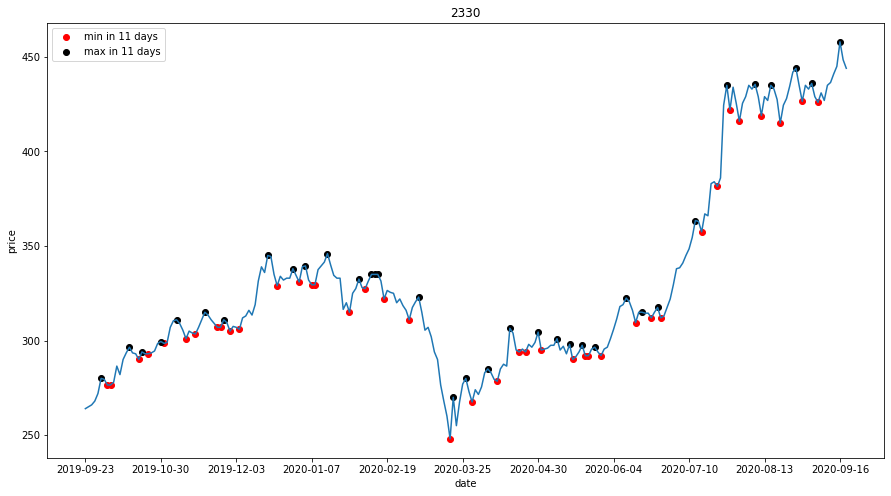

In [8]:
stock = Stock('2330')
df = stock.max_min_price()
stock.plot()

In [94]:
df['volume'].max()*1/5

32567095.0

In [9]:
stock = Trade('2316', date = '2013-01-01', end_date = '2020-06-20')
df = stock.max_min_price()
df['times'] = 0
df['buy_flag'] = False
mode = False
L = [0]

for index, row in df.iterrows():
    if df.loc[index, 'flag'] == 2:
        high = df.loc[index, 'close']
        mode = True
    elif mode and df.loc[index, 'flag'] == 0:
        low = df.loc[index, 'close']
        L.append(high - low)
        mode = False
        if ((high - low) < L[len(L) - 2]) and df.loc[index, 'volume'] < df['volume'].max()*1/4:
            df['times'] += 1
        else:
            df['times'] = 0
    if df.loc[index, 'times'] == 3:
        df.loc[index, 'buy_flag'] = True
        df['times'] = 0
# df['times'] = df['times'].rolling(3).sum()
# df['buy_flag'] = True if df['times'].rolling(3).sum() == 3 else False
df["sell_flag"] = df['close'] < stock.price_ma(10)['10_ma']

In [10]:
stock.summary()

(nan, nan, nan)

In [16]:
stock = Trade('2337', date = '2013-01-01', end_date = '2019-06-20', buy_flag = df['buy_flag'], sell_flag = df["sell_flag"])
res = stock.trading()
res

,volume,open,high,low,close,10_ma,20_ma,investment_trust,foreign_investor,buy_or_sell,shares,balance,profit,return,buy_flag,sell_flag,daily_return
date,,,,,,,,,,,,,,,,,
2013-01-02,15515039,8.80,8.83,8.70,8.73,NaN,NaN,0,6117000,0.0,0.0,1000000.0,0.0,0.0,False,False,NaN
2013-01-03,31791025,8.78,8.96,8.75,8.90,NaN,NaN,-4000,5627000,0.0,0.0,1000000.0,0.0,0.0,False,False,0.0
2013-01-04,20882138,8.93,8.93,8.70,8.77,NaN,NaN,-18000,1983000,0.0,0.0,1000000.0,0.0,0.0,False,False,0.0
2013-01-07,23474170,8.77,9.07,8.66,8.97,NaN,NaN,-73000,2509441,0.0,0.0,1000000.0,0.0,0.0,False,False,0.0
2013-01-08,21819494,8.84,8.84,8.70,8.75,NaN,NaN,-6000,5274000,0.0,0.0,1000000.0,0.0,0.0,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-14,9041334,21.40,21.65,21.35,21.35,21.520,21.2175,0,549481,0.0,0.0,1000000.0,0.0,0.0,False,False,0.0
2019-06-17,9728476,21.30,21.60,21.15,21.20,21.530,21.1650,-728615,-1315200,0.0,0.0,1000000.0,0.0,0.0,False,False,0.0
2019-06-18,14592331,21.40,21.60,21.25,21.55,21.600,21.1375,15000,2258800,0.0,0.0,1000000.0,0.0,0.0,False,False,0.0


In [13]:
import xlwings as xw
xw.view(res)

In [17]:
stock = Trade('2337', date = '2013-01-01')
df = stock.max_min_price()
mode = False
L = [0]
df['buy_flag'] = False
base = stock.price_ma(10)
for index, row in df.iterrows():
    if df.loc[index, 'flag'] == 2:
        high = df.loc[index, 'close']
        mode = True
    elif mode and df.loc[index, 'flag'] == 0:
        low = df.loc[index, 'close']
        L.append(high - low)
        mode = False
        if ((high - low) < L[len(L) - 2]):
            df.loc[index, 'buy_flag'] = True
df["sell_flag"] = df['close'] < base['10_ma']
stock = Trade('2337', date = '2013-01-01', buy_flag = df['buy_flag'], sell_flag = df["sell_flag"])
res, summary = stock.trading(), stock.summary()
res, summary

(              volume   open   high    low  close   10_ma    20_ma  \
 date                                                                
 2013-01-02  15515039   8.80   8.83   8.70   8.73     NaN      NaN   
 2013-01-03  31791025   8.78   8.96   8.75   8.90     NaN      NaN   
 2013-01-04  20882138   8.93   8.93   8.70   8.77     NaN      NaN   
 2013-01-07  23474170   8.77   9.07   8.66   8.97     NaN      NaN   
 2013-01-08  21819494   8.84   8.84   8.70   8.75     NaN      NaN   
 ...              ...    ...    ...    ...    ...     ...      ...   
 2020-09-14  39008020  32.30  32.75  31.85  32.20  31.365  30.4675   
 2020-09-15  25130556  32.40  32.45  31.95  32.35  31.595  30.5625   
 2020-09-16  52003990  32.80  33.05  32.25  32.40  31.905  30.7075   
 2020-09-17  17426533  32.15  32.50  32.05  32.45  32.135  30.9175   
 2020-09-18  15323640  32.60  32.65  32.15  32.45  32.305  31.0900   
 
             investment_trust  foreign_investor  buy_or_sell    shares  \
 date         

Text(0.5, 1.0, '2337')

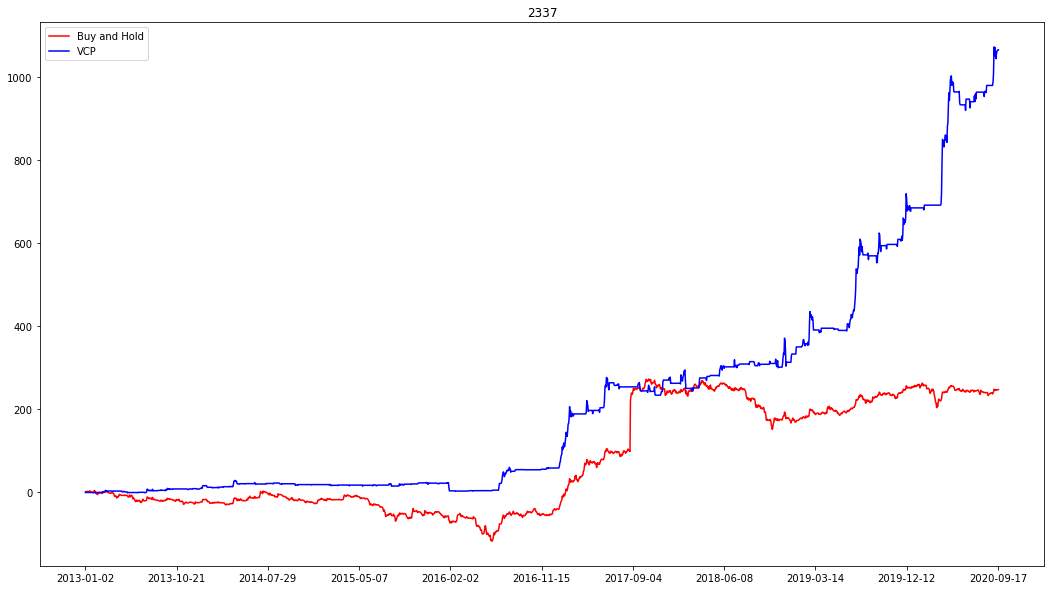

In [18]:
plt.figure(figsize=(18, 10))
stock = Trade('2337', date = '2013-01-01')
df = stock.trading()
df = df.drop(df[df['close'] == 0].index)
df['BaHr_return'] = df['close'].pct_change()
df['BaHr_cum_return'] = df['BaHr_return'].cumsum()*100
plt.plot(df['BaHr_cum_return'], c = 'r', label = 'Buy and Hold')

plt.plot(res.index, res['return'], c = 'blue', label = "VCP")
plt.legend()
new_ticks = []
for k in range(len(df.index)):
    denominator = int(len(df.index) / 10)
    new_ticks.append(df.index[k]) if k%denominator == 0 else 0
plt.xticks(new_ticks)
plt.title(stock.stock_id)

In [12]:
D = {}

In [15]:
for i in range(1517, 9999):
    try:
        stock = Trade(f'{i}', date = '2020-02-01')
        df = stock.max_min_price()
        mode = False
        L = [0]
        df['buy_flag'] = False
        base = stock.price_ma(10)
        for index, row in df.iterrows():
            if df.loc[index, 'flag'] == 2:
                high = df.loc[index, 'close']
                mode = True
            elif mode and df.loc[index, 'flag'] == 0:
                low = df.loc[index, 'close']
                L.append(high - low)
                mode = False
                if ((high - low) < L[len(L) - 2]):
                    df.loc[index, 'buy_flag'] = True
        df["sell_flag"] = df['close'] < base['10_ma']
        stock = Trade(f'{i}', date = '2020-02-01', buy_flag = df['buy_flag'], sell_flag = df["sell_flag"])
        res, summary = stock.trading(), stock.summary()
        D.update({f'{i}':(res.iloc[-1, -3], res.iloc[-1, -4], summary)})
        print(f'{i}:{res.iloc[-1, -3]}, {res.iloc[-1, -4]}, {summary}')
    except KeyError:
        print(f'{i}')

1517:False, 15.86, (1.9801375313128258, 0.514102564102564, 1.0)
1518
1519:False, 15.19, (1.4458132850564578, 0.5713636363636363, 1.0)
1520
1521:False, 5.63, (1.164420622600016, 0.43657894736842107, 0.6666666666666666)
1522:False, 8.12, (1.6264812901209378, 0.74125, 1.0)
1523
1524:False, -2.63, (0.2263455071760017, 0.120625, 0.6666666666666666)
1525:True, -4.14, (0.19252281914610192, 0.07181818181818188, 0.25)
1526:False, 17.93, (0.8741776629765026, 0.5197674418604652, 0.5)
1527:False, -2.46, (-0.12740124875220335, -0.043125, 0.5)
1528:False, 32.61, (2.0216939108980005, 1.4125, 0.6666666666666666)
1529:False, 4.13, (0.9038389271999363, 1.4033333333333335, 0.5)
1530:False, 21.86, (2.4198391748446224, 0.6870588235294117, 0.5)
1531:False, 15.79, (2.605710251955484, 0.7366666666666667, 0.8)
1532:False, 1.51, (1.7317002297251511, 1.0521428571428568, 0.6)
1533:False, 10.74, (1.0930212743604537, 0.445925925925926, 0.75)
1534
1535:False, 20.14, (1.7726430796530772, 0.7985714285714286, 0.5)
1536

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in greater


1590:False, 3.97, (0.41889869217569947, 0.27216216216216227, 0.5)
1591:False, -0.44, (-0.5117958095224738, -0.5566666666666666, 0.0)
1592:False, -3.89, (0.17420960529543708, 0.13099999999999998, 0.4)
1593:False, 16.1, (1.6654829040803818, 1.4408333333333332, 1.0)
1594
1595:False, 25.03, (1.776025921626476, 2.466363636363636, 1.0)
1596
1597:False, 14.75, (1.5270489063972315, 0.9455, 0.75)
1598:False, 18.89, (2.0180234865161437, 0.9943749999999999, 0.3333333333333333)
1599:False, 8.95, (1.1639013939670482, 0.33736842105263154, 0.6666666666666666)
1600
1601
1602
1603:False, 12.12, (1.2305400601300243, 0.5723529411764708, 0.8333333333333334)
1604:False, 10.76, (1.9768322248987418, 0.39037037037037026, 0.75)
1605:False, 2.96, (1.1602469803427253, 0.7436363636363637, 0.8)
1606
1607
1608:False, 7.58, (1.6837085703242363, 0.36599999999999994, 1.0)
1609:False, 14.88, (1.4231717485963635, 0.48100000000000015, 1.0)
1610
1611:False, 12.97, (1.603865329879905, 0.5178124999999999, 0.5)
1612:False, -

KeyboardInterrupt: 

In [39]:
parameter = {"stock_id": '2330',
             "date": datetime.strftime(datetime.today() - 1 * timedelta(days=10), "%Y-%m-%d"),
             "end_date": datetime.strftime(datetime.today() , "%Y-%m-%d"),
             "dataset": "InstitutionalInvestorsBuySell"}
headers = {'Connection': 'close'}
data = requests.get("http://api.finmindtrade.com/api/v2/data", params = parameter, headers = headers)
data = data.json()
data

{'msg': 'success',
 'status': 200,
 'data': {'date': ['2020-07-01',
   '2020-07-01',
   '2020-07-01',
   '2020-07-01',
   '2020-07-01',
   '2020-07-02',
   '2020-07-02',
   '2020-07-02',
   '2020-07-02',
   '2020-07-02',
   '2020-07-03',
   '2020-07-03',
   '2020-07-03',
   '2020-07-03',
   '2020-07-03',
   '2020-07-06',
   '2020-07-06',
   '2020-07-06',
   '2020-07-06',
   '2020-07-06',
   '2020-07-07',
   '2020-07-07',
   '2020-07-07',
   '2020-07-07',
   '2020-07-07',
   '2020-07-08',
   '2020-07-08',
   '2020-07-08',
   '2020-07-08',
   '2020-07-08',
   '2020-07-09',
   '2020-07-09',
   '2020-07-09',
   '2020-07-09',
   '2020-07-09',
   '2020-07-10',
   '2020-07-10',
   '2020-07-10',
   '2020-07-10',
   '2020-07-10'],
  'stock_id': ['2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   '2330',
   

In [40]:
data['data'].keys()

dict_keys(['date', 'stock_id', 'buy', 'name', 'sell'])

In [41]:
data['data']['name']

['Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust']

In [61]:
parameter.update({"dataset": "TaiwanStockPrice"})
data2 = requests.get("http://api.finmindtrade.com/api/v2/data", params = parameter, headers = headers)
data2 = data2.json()
data2

{'msg': 'success',
 'status': 200,
 'data': {'date': ['2020-07-01',
   '2020-07-02',
   '2020-07-03',
   '2020-07-06',
   '2020-07-07',
   '2020-07-08',
   '2020-07-09',
   '2020-07-10'],
  'stock_id': ['2330', '2330', '2330', '2330', '2330', '2330', '2330', '2330'],
  'Trading_Volume': [29685342,
   37789178,
   55656987,
   57256220,
   59046323,
   33813218,
   37410376,
   60902108],
  'Trading_money': [9400765756,
   12119073560,
   18280314743,
   19200718243,
   20143258406,
   11522915649,
   12912747970,
   21298923681],
  'open': [315.0, 319.0, 327.0, 332.5, 343.5, 337.5, 346.0, 352.5],
  'max': [318.0, 322.0, 330.5, 338.0, 346.0, 342.5, 347.0, 353.0],
  'min': [314.0, 318.0, 326.5, 332.0, 338.0, 337.5, 343.0, 345.5],
  'close': [317.5, 322.0, 329.5, 338.0, 338.5, 341.0, 345.0, 348.5],
  'spread': [4.5, 4.5, 7.5, 8.5, 0.5, 2.5, 4.0, 3.5],
  'Trading_turnover': [15617,
   18355,
   30235,
   31866,
   32076,
   16673,
   20205,
   32227]}}

In [43]:
data2['data'].keys()

dict_keys(['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'spread', 'Trading_turnover'])

In [44]:
data3 = {**data['data'], **data2['data']}

In [47]:
data3

{'date': ['2020-07-01',
  '2020-07-02',
  '2020-07-03',
  '2020-07-06',
  '2020-07-07',
  '2020-07-08',
  '2020-07-09',
  '2020-07-10'],
 'stock_id': ['2330', '2330', '2330', '2330', '2330', '2330', '2330', '2330'],
 'buy': [59000,
  676000,
  0,
  18160967,
  356000,
  336000,
  260000,
  0,
  17348146,
  580000,
  388000,
  220000,
  0,
  34584608,
  3627000,
  873000,
  746000,
  0,
  29445371,
  341000,
  662000,
  384000,
  0,
  30830992,
  93000,
  434000,
  831000,
  0,
  17628071,
  427000,
  349000,
  12000,
  0,
  21852096,
  494000,
  512000,
  366000,
  0,
  40571832,
  304000],
 'name': ['Dealer_Hedging',
  'Dealer_self',
  'Foreign_Dealer_Self',
  'Foreign_Investor',
  'Investment_Trust',
  'Dealer_Hedging',
  'Dealer_self',
  'Foreign_Dealer_Self',
  'Foreign_Investor',
  'Investment_Trust',
  'Dealer_Hedging',
  'Dealer_self',
  'Foreign_Dealer_Self',
  'Foreign_Investor',
  'Investment_Trust',
  'Dealer_Hedging',
  'Dealer_self',
  'Foreign_Dealer_Self',
  'Foreign_Inv

In [50]:
data['data']['name']

['Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust',
 'Dealer_Hedging',
 'Dealer_self',
 'Foreign_Dealer_Self',
 'Foreign_Investor',
 'Investment_Trust']

In [51]:
data = pd.DataFrame(data['data'])
data.set_index('date', inplace = True)
investment_trust = data[data['name'] == 'Investment_Trust']
investment_trust.insert(2, 'investment_trust', investment_trust['buy'] - investment_trust['sell'])
investment_trust = investment_trust.drop(columns = ['buy', 'name', 'sell', 'stock_id'])
foreign_investor = data[data['name'] == 'Foreign_Investor']
foreign_investor.insert(2, 'foreign_investor', foreign_investor['buy'] - foreign_investor['sell'])
foreign_investor = foreign_investor.drop(columns = ['buy', 'name', 'sell', 'stock_id'])
data = pd.merge(investment_trust, foreign_investor, on = ['date'])

In [53]:
dict(data)

{'investment_trust': date
 2020-07-01     122000
 2020-07-02     472000
 2020-07-03    3316000
 2020-07-06      -8000
 2020-07-07    -204000
 2020-07-08     -81000
 2020-07-09      86000
 2020-07-10      24676
 Name: investment_trust, dtype: int64, 'foreign_investor': date
 2020-07-01     9092857
 2020-07-02     6445063
 2020-07-03    24696749
 2020-07-06    11930066
 2020-07-07    11774916
 2020-07-08     1383424
 2020-07-09    10482241
 2020-07-10    23961649
 Name: foreign_investor, dtype: int64}

In [62]:
data2 = pd.DataFrame(data2['data'])
data2.set_index('date', inplace = True)
data2 = data2.drop(columns = ['Trading_money', 'spread', 'Trading_turnover', 'stock_id'])
data2.columns = ['volume', 'open', 'high', 'low', 'close']
data2

,volume,open,high,low,close
date,,,,,
2020-07-01,29685342,315.0,318.0,314.0,317.5
2020-07-02,37789178,319.0,322.0,318.0,322.0
2020-07-03,55656987,327.0,330.5,326.5,329.5
2020-07-06,57256220,332.5,338.0,332.0,338.0
2020-07-07,59046323,343.5,346.0,338.0,338.5
2020-07-08,33813218,337.5,342.5,337.5,341.0
2020-07-09,37410376,346.0,347.0,343.0,345.0
2020-07-10,60902108,352.5,353.0,345.5,348.5


In [63]:
dict(data2)

{'volume': date
 2020-07-01    29685342
 2020-07-02    37789178
 2020-07-03    55656987
 2020-07-06    57256220
 2020-07-07    59046323
 2020-07-08    33813218
 2020-07-09    37410376
 2020-07-10    60902108
 Name: volume, dtype: int64, 'open': date
 2020-07-01    315.0
 2020-07-02    319.0
 2020-07-03    327.0
 2020-07-06    332.5
 2020-07-07    343.5
 2020-07-08    337.5
 2020-07-09    346.0
 2020-07-10    352.5
 Name: open, dtype: float64, 'high': date
 2020-07-01    318.0
 2020-07-02    322.0
 2020-07-03    330.5
 2020-07-06    338.0
 2020-07-07    346.0
 2020-07-08    342.5
 2020-07-09    347.0
 2020-07-10    353.0
 Name: high, dtype: float64, 'low': date
 2020-07-01    314.0
 2020-07-02    318.0
 2020-07-03    326.5
 2020-07-06    332.0
 2020-07-07    338.0
 2020-07-08    337.5
 2020-07-09    343.0
 2020-07-10    345.5
 Name: low, dtype: float64, 'close': date
 2020-07-01    317.5
 2020-07-02    322.0
 2020-07-03    329.5
 2020-07-06    338.0
 2020-07-07    338.5
 2020-07-08    3

In [73]:
data3 = {**dict(data), **dict(data2)}

In [66]:
pd.DataFrame(data3)

,investment_trust,foreign_investor,volume,open,high,low,close
date,,,,,,,
2020-07-01,122000,9092857,29685342,315.0,318.0,314.0,317.5
2020-07-02,472000,6445063,37789178,319.0,322.0,318.0,322.0
2020-07-03,3316000,24696749,55656987,327.0,330.5,326.5,329.5
2020-07-06,-8000,11930066,57256220,332.5,338.0,332.0,338.0
2020-07-07,-204000,11774916,59046323,343.5,346.0,338.0,338.5
2020-07-08,-81000,1383424,33813218,337.5,342.5,337.5,341.0
2020-07-09,86000,10482241,37410376,346.0,347.0,343.0,345.0
2020-07-10,24676,23961649,60902108,352.5,353.0,345.5,348.5


In [74]:
import json
stock_id = 2330
with open(f'{stock_id}.json', 'w') as file:
    json.dump(data3, file)

TypeError: Object of type Series is not JSON serializable

In [80]:
json.dumps(data3)

TypeError: Object of type Series is not JSON serializable

In [77]:
df = pd.DataFrame(data3).to_json()

In [79]:
type(df)

str